# info

This script takes raw XCMS file as input.

The tasks are:
- cell number correction
- separate each of the five patients, which are called Batch in the original file.
- quantile normalization across runs of each individual patient.
    
Then the output should be a visualization of all samples

In [1]:
import pandas, seaborn, numpy

import sklearn, sklearn.decomposition, sklearn.preprocessing
import scipy, scipy.stats

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(12, 8)})

# 0. user-defined variables

In [2]:
data_file = '/home/adrian/gd15/hi/research/huvec/data/untargetted/ROSA_ACID_NEG_UT_NOMISNORM_AllBatches_untransformed.xlsx'

# 1. read data

In [3]:
original_data = pandas.read_excel(data_file)
original_data.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,287.490913,468.605181,189.373225,576.720535,...,465.887121,538.617987,445.230813,507.349690,316.742342,1704.549078,2324.193317,3058.642052,2278.023742,2335.314302
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,180.314261,538.342307,130.499826,603.217924,...,715.677228,713.253520,518.775906,755.134538,123.522480,2331.474888,3382.452083,2496.359276,3421.428464,3531.897024
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,284.725250,346.699905,391.221386,430.336737,...,430.145981,471.505944,371.179769,556.979273,103.571678,1891.004688,1694.637198,1856.663944,1758.452722,1738.477130
3,EC_Rosa_1_695,31,EGM,2,NaN,0,215.383340,632.252573,521.709396,334.036661,...,632.334182,668.358819,546.989703,731.548349,229.357094,1411.265683,1856.889097,2134.864349,2284.850823,2055.847626
4,EC_Rosa_1_711,32,EGM,2,NaN,0,308.400509,461.052002,269.282993,759.247147,...,327.326707,452.810036,324.323485,546.560671,12.509056,1898.663392,2342.170593,2813.164141,2517.026143,2493.479576


In [4]:
info = original_data.iloc[:, :6]
info.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME
0,EC_Rosa_1_659,4,EGM,1,480000.0,0
1,EC_Rosa_1_666,5,EGM,1,480000.0,0
2,EC_Rosa_1_668,3,EGM,1,480000.0,0
3,EC_Rosa_1_695,31,EGM,2,NaN,0
4,EC_Rosa_1_711,32,EGM,2,NaN,0


In [5]:
intensities = original_data.iloc[:, 6:]
intensities.head()

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,287.490913,468.605181,189.373225,576.720535,321.251154,490.368895,6963.243332,1574.419726,205.341230,224.308740,...,465.887121,538.617987,445.230813,507.349690,316.742342,1704.549078,2324.193317,3058.642052,2278.023742,2335.314302
1,180.314261,538.342307,130.499826,603.217924,474.653477,426.956672,3643.910179,1315.831068,154.358128,170.502985,...,715.677228,713.253520,518.775906,755.134538,123.522480,2331.474888,3382.452083,2496.359276,3421.428464,3531.897024
2,284.725250,346.699905,391.221386,430.336737,513.463286,895.284301,4228.235643,1443.006843,212.677132,391.189120,...,430.145981,471.505944,371.179769,556.979273,103.571678,1891.004688,1694.637198,1856.663944,1758.452722,1738.477130
3,215.383340,632.252573,521.709396,334.036661,463.543369,871.905092,5835.753747,1678.712440,512.057985,1568.892520,...,632.334182,668.358819,546.989703,731.548349,229.357094,1411.265683,1856.889097,2134.864349,2284.850823,2055.847626
4,308.400509,461.052002,269.282993,759.247147,568.430834,580.175396,1893.502277,1910.773244,312.684534,710.027443,...,327.326707,452.810036,324.323485,546.560671,12.509056,1898.663392,2342.170593,2813.164141,2517.026143,2493.479576


In [6]:
peak_names = original_data.columns.to_list()[6:]
print(len(peak_names))
peak_names[:10]

1230


['X59.01097',
 'X61.017890000000001',
 'X67.016220000000004',
 'X74.021450000000002',
 'X77.052040000000005',
 'X77.052049999999994',
 'X78.956580000000002',
 'X78.956770000000006',
 'X79.955420000000004',
 'X80.962869999999995']

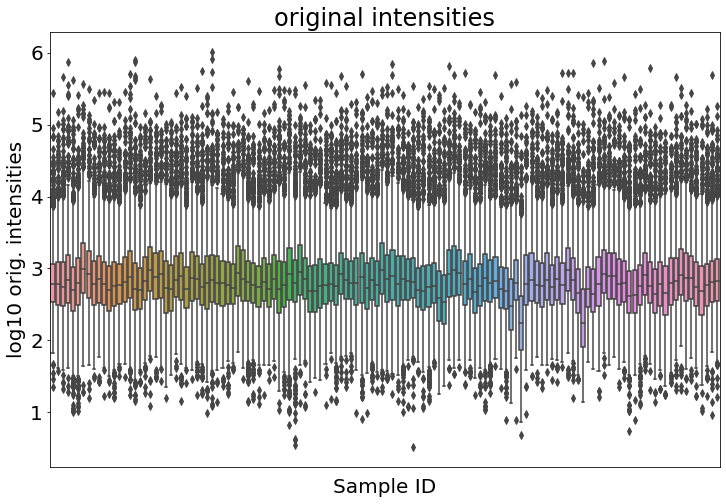

In [7]:
plotting_data = intensities.transpose()
plotting_data.head()

g = seaborn.boxplot(data=numpy.log10(plotting_data))
g.set(xticklabels=[], ylabel='log10 orig. intensities', xlabel='Sample ID', title='original intensities')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

# 2. normalize data by cell numbers

In [8]:
intensities_by_cell = intensities.div(original_data['Cell  number']/1e6, axis=0)
intensities_by_cell.head(10)

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,598.939402,976.260794,394.527553,1201.501115,669.273238,1021.601865,14506.756942,3280.041095,427.794229,467.309876,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,375.654710,1121.546473,271.874638,1256.704008,988.861411,889.493067,7591.479539,2741.314726,321.579434,355.214552,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,593.177604,722.291469,815.044553,896.534868,1069.715180,1865.175628,8808.824257,3006.264256,443.077358,814.977334,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,621.152501,1825.424702,467.294062,2333.133711,1907.808060,2790.453418,23646.966493,8010.429693,660.939824,654.341910,...,2698.087973,2887.812940,2308.506988,2334.598693,2034.044873,9038.588512,11058.163249,12333.298055,12270.745784,10790.108692


In [9]:
normalized_met_by_cell = pandas.concat([info, intensities_by_cell.reindex(info.index)], axis=1)
normalized_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,598.939402,976.260794,394.527553,1201.501115,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,375.654710,1121.546473,271.874638,1256.704008,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,593.177604,722.291469,815.044553,896.534868,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
3,EC_Rosa_1_695,31,EGM,2,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EC_Rosa_1_711,32,EGM,2,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. remove conditions without cell numbers

In [10]:
# remove conditions for which cell numbers are not available
print('conditions before filtering {}'.format(normalized_met_by_cell.shape[0]))
finite_normalized_met_by_cell = normalized_met_by_cell[numpy.isfinite(normalized_met_by_cell['Cell  number']) == True]
print('conditions after filtering {}'.format(finite_normalized_met_by_cell.shape[0]))

conditions before filtering 130
conditions after filtering 121


In [11]:
finite_normalized_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,598.939402,976.260794,394.527553,1201.501115,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,375.654710,1121.546473,271.874638,1256.704008,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,593.177604,722.291469,815.044553,896.534868,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,621.152501,1825.424702,467.294062,2333.133711,...,2698.087973,2887.812940,2308.506988,2334.598693,2034.044873,9038.588512,11058.163249,12333.298055,12270.745784,10790.108692
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,761.738204,1880.681355,346.274473,2111.788781,...,1861.632957,2131.258746,1706.691679,2467.284050,1637.665077,8454.690040,10424.083896,11610.791792,10437.888669,9955.916753


# 4. bring it all to log10

In [12]:
info = finite_normalized_met_by_cell.iloc[:, :6]
data = finite_normalized_met_by_cell.iloc[:, 6:]
transformed = data.apply(numpy.log10)
log10_finite_normalize_met_by_cell = pandas.concat([info, transformed.reindex(info.index)], axis=1)
log10_finite_normalize_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,2.777383,2.989566,2.596077,3.079724,...,2.987039,3.050040,2.967344,3.024066,2.819465,3.550368,3.685031,3.804287,3.676317,3.687104
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,2.574789,3.049817,2.434369,3.099233,...,3.173476,3.172003,3.033739,3.196783,2.410505,3.686390,3.847990,3.716066,3.852966,3.866767
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,2.773185,2.858712,2.911181,2.952567,...,2.952375,2.992246,2.888343,3.064598,2.334000,3.595451,3.547835,3.587492,3.563889,3.558928
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,2.793198,3.261364,2.669590,3.367940,...,3.431056,3.460569,3.363331,3.368212,3.308361,3.956101,4.043683,4.091079,4.088871,4.033026
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,2.881806,3.274315,2.539420,3.324650,...,3.269894,3.328636,3.232155,3.392219,3.214225,3.927098,4.018038,4.064862,4.018613,3.998081


[Text(0, 0.5, 'log10 Intensity'), Text(0.5, 0, 'Peak ID')]

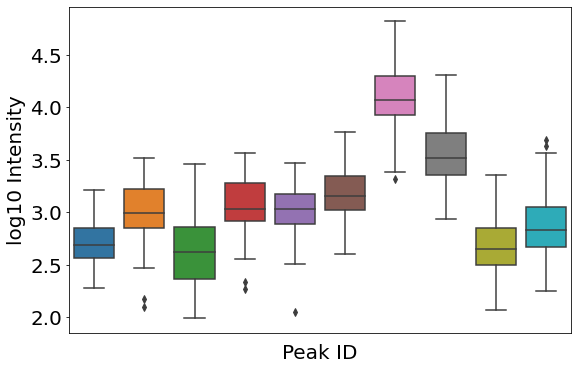

In [13]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=log10_finite_normalize_met_by_cell[peak_names[:10]], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(ylabel='log10 Intensity', xlabel='Peak ID')

# 5. break in to patient specific samples. then perform quantile normalization

In [14]:
log10_finite_normalize_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,2.777383,2.989566,2.596077,3.079724,...,2.987039,3.050040,2.967344,3.024066,2.819465,3.550368,3.685031,3.804287,3.676317,3.687104
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,2.574789,3.049817,2.434369,3.099233,...,3.173476,3.172003,3.033739,3.196783,2.410505,3.686390,3.847990,3.716066,3.852966,3.866767
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,2.773185,2.858712,2.911181,2.952567,...,2.952375,2.992246,2.888343,3.064598,2.334000,3.595451,3.547835,3.587492,3.563889,3.558928
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,2.793198,3.261364,2.669590,3.367940,...,3.431056,3.460569,3.363331,3.368212,3.308361,3.956101,4.043683,4.091079,4.088871,4.033026
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,2.881806,3.274315,2.539420,3.324650,...,3.269894,3.328636,3.232155,3.392219,3.214225,3.927098,4.018038,4.064862,4.018613,3.998081


1
(27, 1236)


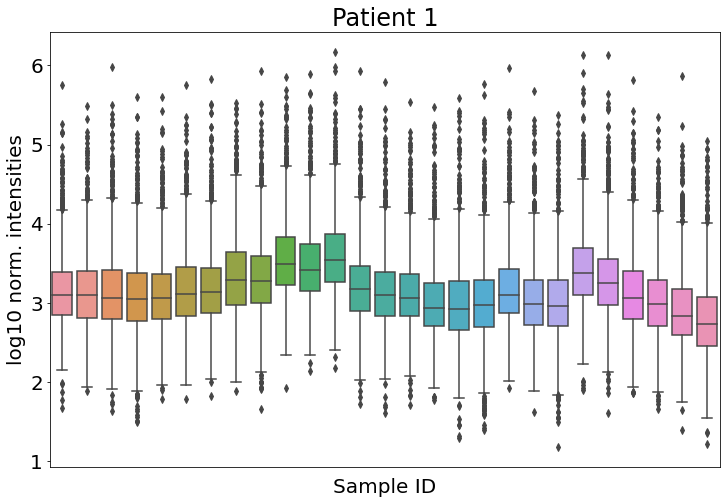

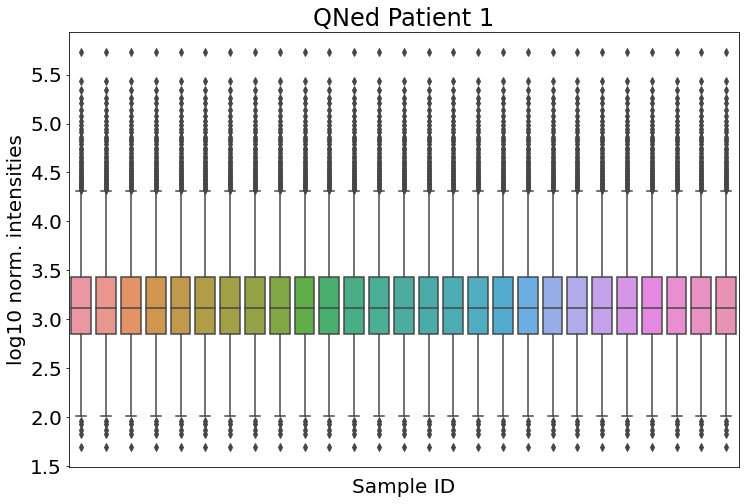

2
(24, 1236)


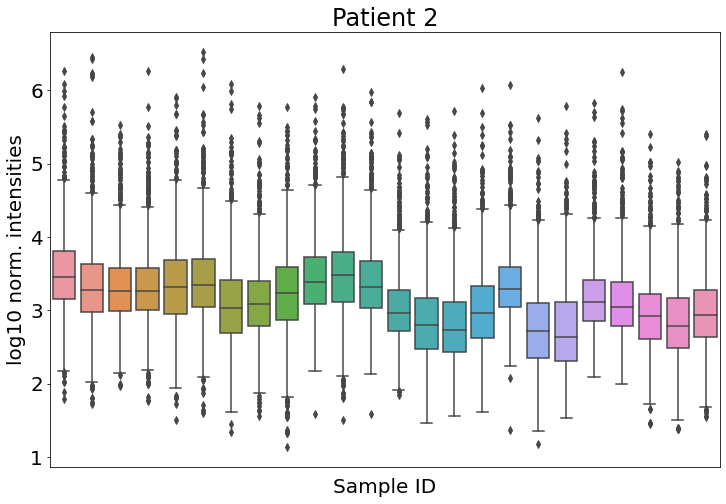

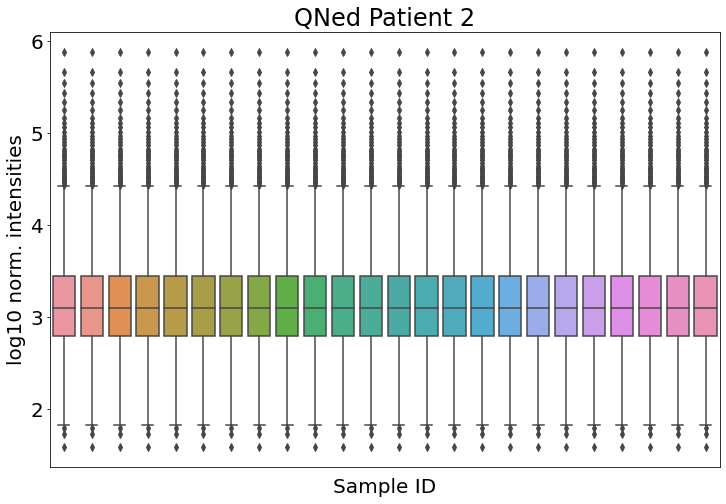

3
(23, 1236)


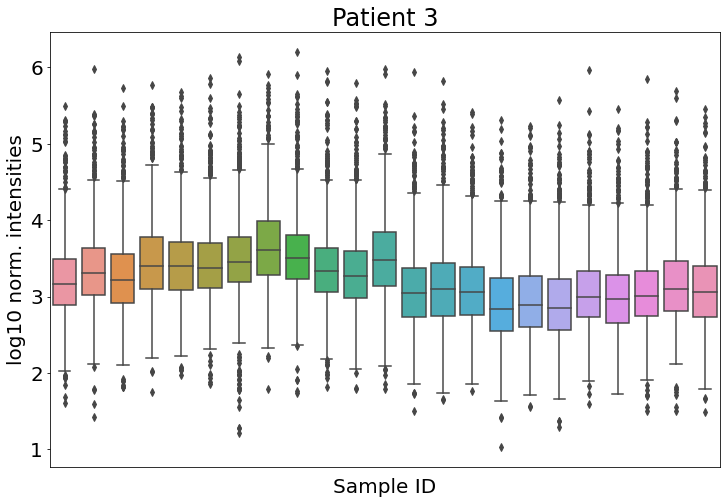

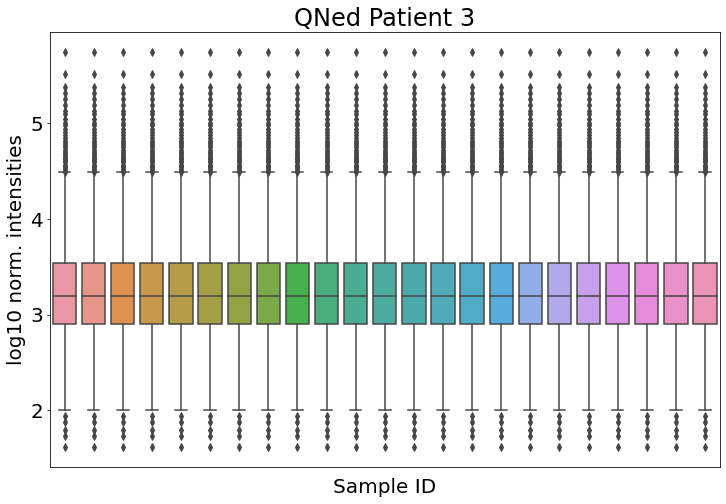

4
(24, 1236)


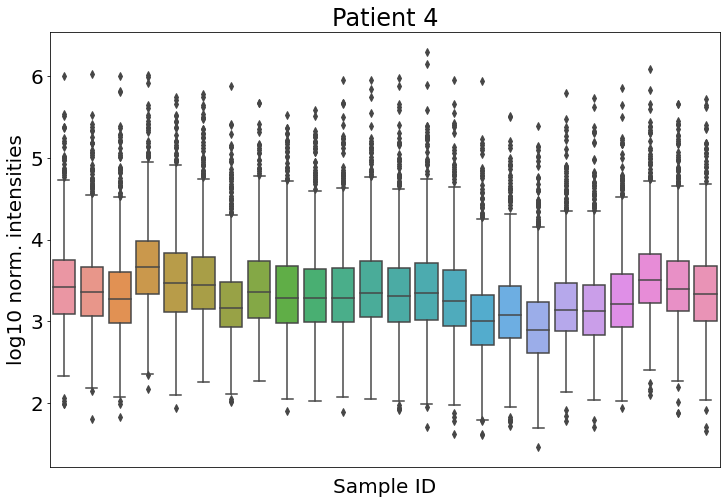

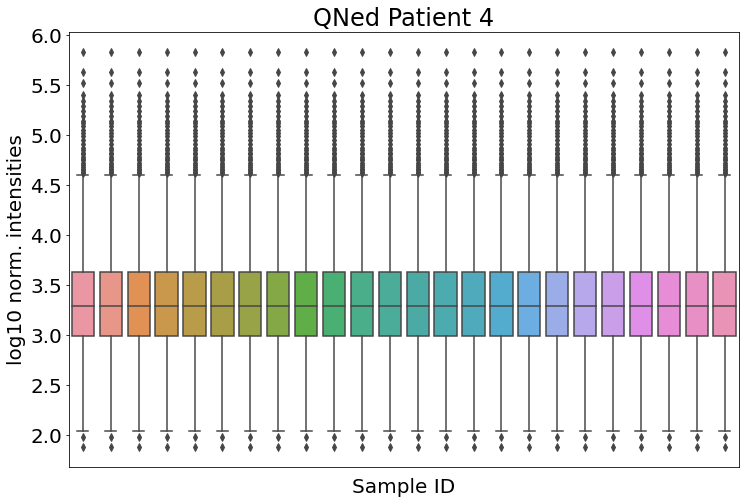

5
(23, 1236)


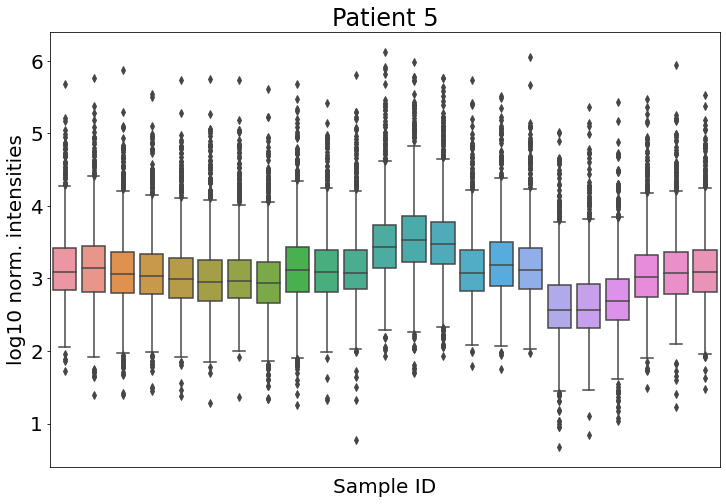

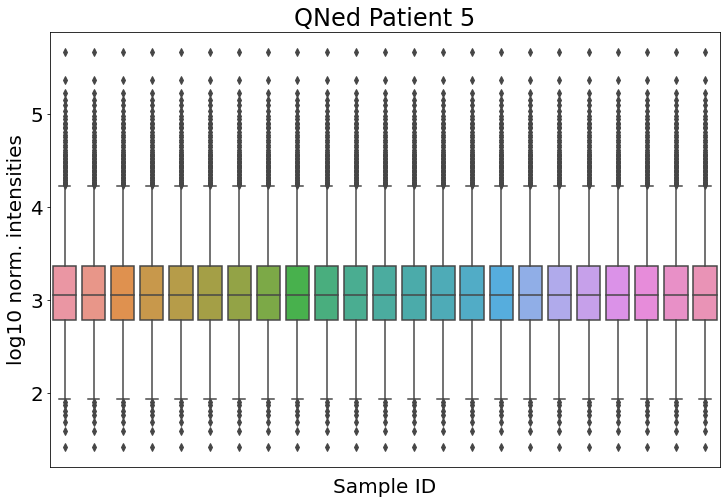

In [15]:
batches = [1, 2, 3, 4, 5]
frames = []

for batch in batches:
    print(batch)
    
    patient_df = log10_finite_normalize_met_by_cell[log10_finite_normalize_met_by_cell['Batch'] == batch]
    print(patient_df.shape)
    
    ###
    ### plot intensities before QN
    ###
    tdf = patient_df.transpose()
    tdf.drop(['Unnamed: 0', 'Number', 'Treatment', 'Batch', 'Cell  number', 'TIME'], axis=0, inplace=True)
    tdf.head()
    
    g = seaborn.boxplot(data=tdf)
    g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID', title='Patient {}'.format(batch))
    g.tick_params(bottom=False)
    matplotlib.pyplot.show()
    
    ###
    ### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
    ###
    
    # step 1/3: sorting sample values
    df_sorted = pandas.DataFrame(numpy.sort(tdf.values, axis=0), index=tdf.index, columns=tdf.columns)
    # step 2/3: averaging rank values across samples
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = numpy.arange(1, len(df_mean) + 1)
    # step 3/3: re-ordering samples
    df_qn = tdf.rank(method="min").stack().astype(int).map(df_mean).unstack()
        
    # plot intensities after QN
    g = seaborn.boxplot(data=df_qn)
    g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID', title='QNed Patient {}'.format(batch))
    g.tick_params(bottom=False)
    matplotlib.pyplot.show()
    
    ###
    ### re-join
    ###
    qn_peaks = df_qn.transpose()
    qn_peaks.insert(0, 'Patient', log10_finite_normalize_met_by_cell['Batch'])
    qn_peaks.insert(0, 'Time', log10_finite_normalize_met_by_cell['TIME']) 
    qn_peaks.insert(0, 'Treatment', log10_finite_normalize_met_by_cell['Treatment']) 
    qn_peaks.insert(0, 'Sample ID', log10_finite_normalize_met_by_cell['Unnamed: 0'])
    qn_peaks.head()
    
    ###
    ### append frames
    ###
    frames.append(qn_peaks)

In [16]:
result = pandas.concat(frames)
print(result.shape)
result.head()

(121, 1234)


,Sample ID,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,EGM,0,1,2.782314,2.993085,2.620780,3.089566,2.826366,3.015916,...,2.988611,3.059485,2.965514,3.031444,2.821468,3.577312,3.700449,3.840751,3.695896,3.705798
1,EC_Rosa_1_666,EGM,0,1,2.601757,3.072107,2.406943,3.115155,3.022561,2.988110,...,3.195526,3.190904,3.052213,3.213794,2.392288,3.741334,3.881998,3.778547,3.893548,3.901253
2,EC_Rosa_1_668,EGM,0,1,2.823494,2.900750,2.957281,2.998298,3.088034,3.291872,...,2.997696,3.058846,2.926512,3.117851,2.332418,3.624233,3.570702,3.617147,3.592576,3.582752
12,EC_Rosa_1_667,1,4,1,2.789907,2.875829,2.853179,3.001867,2.971567,3.201558,...,2.990473,3.022561,3.005396,3.190074,1.695046,3.598468,3.720693,3.823147,3.763575,3.769509
13,EC_Rosa_1_672,1,4,1,2.644195,3.042768,2.354002,2.939938,2.792918,3.295087,...,2.930662,2.941550,2.840867,3.001867,2.662403,3.455557,3.475355,3.600501,3.633099,3.617147


# 6. work with fold-change values

## 6.1. compute fold-change values

In [17]:
patients = [1, 2, 3, 4, 5]
time_points = [4, 24]
treatments = [1, 10, 100]
peak_mz_names = result.columns[4:]
print(peak_mz_names[:10])

Index(['X59.01097', 'X61.017890000000001', 'X67.016220000000004',
       'X74.021450000000002', 'X77.052040000000005', 'X77.052049999999994',
       'X78.956580000000002', 'X78.956770000000006', 'X79.955420000000004',
       'X80.962869999999995'],
      dtype='object')


In [18]:
fold_change = {}

for peak_mz_name in peak_mz_names:
    
    fold_change['Patient'] = []
    fold_change['Time point'] = []
    fold_change['Treatment'] = []
    fold_change[peak_mz_name] = []
    
    for patient in patients:
        for time_point in time_points:
            for treatment in treatments:
                
                perturbation = result[(result['Patient'] == patient) & (result['Time'] == time_point) & (result['Treatment'] == treatment)][peak_mz_name].values
                reference = result[(result['Patient'] == patient) & (result['Time'] == time_point) & (result['Treatment'] == 'EGM')][peak_mz_name].values
                
                if numpy.min([len(perturbation), len(reference)]) > 0:
                    
                    num = numpy.log2(10**(numpy.median(perturbation)))
                    den = numpy.log2(10**(numpy.median(reference)))
                    log2FC = num - den
                    
                    fold_change['Patient'].append(patient)
                    fold_change['Time point'].append(time_point)
                    fold_change['Treatment'].append(treatment)
                    fold_change[peak_mz_name].append(log2FC)

In [19]:
fcdf = pandas.DataFrame.from_dict(fold_change)
print(fcdf.shape)
fcdf.head()

(29, 1233)


,Patient,Time point,Treatment,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,1,4,1,0.399380,0.364737,0.079219,-0.002439,0.213799,0.587217,0.167082,...,0.653499,0.391612,0.724295,-0.189454,-0.994415,-0.466579,-0.381628,-0.128967,0.006990,-0.221678
1,1,4,10,0.267059,0.537148,-0.526970,0.265058,0.250591,0.124649,-0.245610,...,1.079787,0.916029,1.193568,0.381641,-2.097145,0.132662,0.152658,0.200683,-0.336537,0.093746
2,1,4,100,0.378911,0.543563,-0.879734,0.314414,0.476670,0.370595,0.326279,...,0.791973,0.669473,0.727228,0.072475,-0.994415,0.029480,0.017771,0.169786,0.182684,-0.039107
3,1,24,1,0.045810,-0.082940,-0.317764,0.095721,0.318387,0.026868,-0.315838,...,-0.400741,-0.419110,-0.227175,-0.071420,-0.964235,-0.371348,-0.225176,-0.261598,-0.114983,0.812620
4,1,24,10,-0.085989,-0.197981,-1.207604,0.042725,0.335833,0.166158,-0.252091,...,-0.896143,-0.649981,-0.692598,-0.375253,-1.256356,0.135555,-0.047351,-0.074639,0.075210,1.039795


## 6.2 visualize samples

In [20]:
pca_input = fcdf.iloc[:, 3:]
pca_input.head()

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,0.399380,0.364737,0.079219,-0.002439,0.213799,0.587217,0.167082,-0.344627,0.476345,0.263765,...,0.653499,0.391612,0.724295,-0.189454,-0.994415,-0.466579,-0.381628,-0.128967,0.006990,-0.221678
1,0.267059,0.537148,-0.526970,0.265058,0.250591,0.124649,-0.245610,-0.487435,0.096416,-0.120342,...,1.079787,0.916029,1.193568,0.381641,-2.097145,0.132662,0.152658,0.200683,-0.336537,0.093746
2,0.378911,0.543563,-0.879734,0.314414,0.476670,0.370595,0.326279,0.125717,0.571724,0.271983,...,0.791973,0.669473,0.727228,0.072475,-0.994415,0.029480,0.017771,0.169786,0.182684,-0.039107
3,0.045810,-0.082940,-0.317764,0.095721,0.318387,0.026868,-0.315838,-0.760481,0.183785,0.541641,...,-0.400741,-0.419110,-0.227175,-0.071420,-0.964235,-0.371348,-0.225176,-0.261598,-0.114983,0.812620
4,-0.085989,-0.197981,-1.207604,0.042725,0.335833,0.166158,-0.252091,-0.319130,0.078640,0.214930,...,-0.896143,-0.649981,-0.692598,-0.375253,-1.256356,0.135555,-0.047351,-0.074639,0.075210,1.039795


In [21]:
fcdf.head()

,Patient,Time point,Treatment,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,1,4,1,0.399380,0.364737,0.079219,-0.002439,0.213799,0.587217,0.167082,...,0.653499,0.391612,0.724295,-0.189454,-0.994415,-0.466579,-0.381628,-0.128967,0.006990,-0.221678
1,1,4,10,0.267059,0.537148,-0.526970,0.265058,0.250591,0.124649,-0.245610,...,1.079787,0.916029,1.193568,0.381641,-2.097145,0.132662,0.152658,0.200683,-0.336537,0.093746
2,1,4,100,0.378911,0.543563,-0.879734,0.314414,0.476670,0.370595,0.326279,...,0.791973,0.669473,0.727228,0.072475,-0.994415,0.029480,0.017771,0.169786,0.182684,-0.039107
3,1,24,1,0.045810,-0.082940,-0.317764,0.095721,0.318387,0.026868,-0.315838,...,-0.400741,-0.419110,-0.227175,-0.071420,-0.964235,-0.371348,-0.225176,-0.261598,-0.114983,0.812620
4,1,24,10,-0.085989,-0.197981,-1.207604,0.042725,0.335833,0.166158,-0.252091,...,-0.896143,-0.649981,-0.692598,-0.375253,-1.256356,0.135555,-0.047351,-0.074639,0.075210,1.039795


In [22]:
pca = sklearn.decomposition.PCA(n_components=2)
x = sklearn.preprocessing.StandardScaler().fit_transform(pca_input)
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)
print(pca.explained_variance_ratio_)

(29, 2)
[0.21421753 0.14119523]


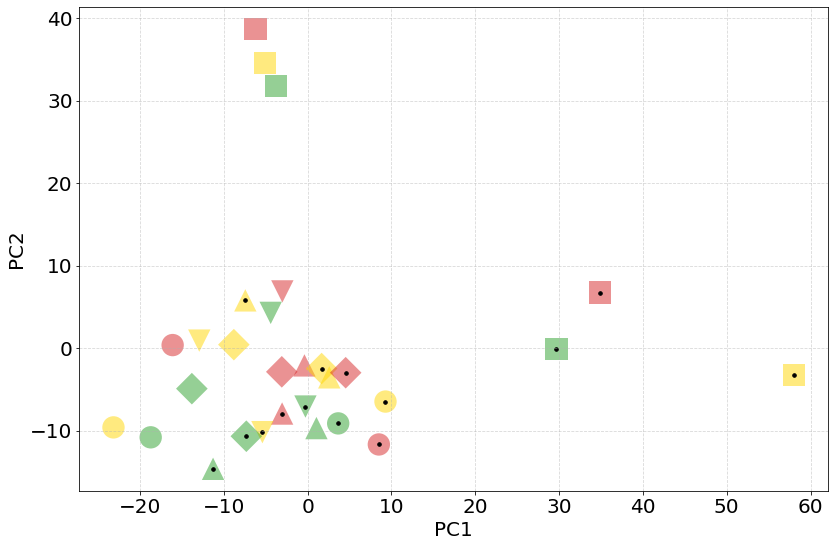

In [23]:
for i in range(len(x)):
    
    # marker based on patient
    patient = fcdf.iloc[i, 0]
    if patient == 1:
        the_marker = 'o'
    elif patient == 2:
        the_marker = 's'
    elif patient == 3:
        the_marker = '^'
    elif patient == 4:
        the_marker = 'v'
    elif patient == 5:
        the_marker = 'D'
    else:
        print('error')
    
    # color based on treatment
    treatment = fcdf.iloc[i, 2]
    if treatment == 1:
        the_color = 'tab:green'
    elif treatment == 10:
        the_color = 'gold'
    elif treatment == 100:
        the_color = 'tab:red'
    else:
        print('error')
    
    matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c=the_color, s=500, alpha=0.5, edgecolors='none', marker=the_marker)
    
    if fcdf.iloc[i, 1] == 24:
        matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c='black', s=50, edgecolors='black', marker='.')
        
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(alpha=0.5, ls='--')
matplotlib.pyplot.tight_layout()

# 6.3. store data for downstream analysis

In [24]:
storing_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/patient-specific/patient-specific_fold_changes.csv'
fcdf.to_csv(storing_file)
print(fcdf.shape)
fcdf.head()

(29, 1233)


,Patient,Time point,Treatment,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,1,4,1,0.399380,0.364737,0.079219,-0.002439,0.213799,0.587217,0.167082,...,0.653499,0.391612,0.724295,-0.189454,-0.994415,-0.466579,-0.381628,-0.128967,0.006990,-0.221678
1,1,4,10,0.267059,0.537148,-0.526970,0.265058,0.250591,0.124649,-0.245610,...,1.079787,0.916029,1.193568,0.381641,-2.097145,0.132662,0.152658,0.200683,-0.336537,0.093746
2,1,4,100,0.378911,0.543563,-0.879734,0.314414,0.476670,0.370595,0.326279,...,0.791973,0.669473,0.727228,0.072475,-0.994415,0.029480,0.017771,0.169786,0.182684,-0.039107
3,1,24,1,0.045810,-0.082940,-0.317764,0.095721,0.318387,0.026868,-0.315838,...,-0.400741,-0.419110,-0.227175,-0.071420,-0.964235,-0.371348,-0.225176,-0.261598,-0.114983,0.812620
4,1,24,10,-0.085989,-0.197981,-1.207604,0.042725,0.335833,0.166158,-0.252091,...,-0.896143,-0.649981,-0.692598,-0.375253,-1.256356,0.135555,-0.047351,-0.074639,0.075210,1.039795


# 7. work with z-scores

## 7.1. compute z-scores

### 7.1.1. define metabolites with an abs log2 FC > 1.5 across 3 out 5 patients

In [25]:
working_peaks = []

responders = {}
for peak_name in peak_names:
    responders[peak_name] = 0

for patient in patients:
    sub = result[result['Patient'] == patient]
    
    for peak_name in peak_names:
        trends = []
        for time_point in time_points:
            for treatment in treatments:
                box = sub[(sub['Time'] == time_point) & (sub['Treatment'] == treatment)][peak_name].to_list()
                if len(box) > 1:
                    trends.append(numpy.median(box))
                
        # compute variation
        variation = numpy.max(trends) - numpy.min(trends)
        if variation > numpy.log10(1.5): 
            responders[peak_name] = responders[peak_name] + 1

for peak_name in peak_names:
    if responders[peak_name] >= 3:
        working_peaks.append(peak_name)
print(len(peak_names), len(working_peaks))

1230 1150


In [26]:
selected_columns = ['Treatment', 'Time', 'Patient']
for element in working_peaks:
    selected_columns.append(element)
print(selected_columns[:10])

['Treatment', 'Time', 'Patient', 'X59.01097', 'X61.017890000000001', 'X67.016220000000004', 'X74.021450000000002', 'X77.052049999999994', 'X78.956770000000006', 'X79.955420000000004']


In [27]:
var_df = result[selected_columns]
var_df_clean = var_df[var_df['Treatment'] != 'EGM']
print(result.shape)
print(var_df.shape)
print(var_df_clean.shape)
var_df_clean.tail(25)

(121, 1234)
(121, 1153)
(85, 1153)


,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052049999999994,X78.956770000000006,X79.955420000000004,...,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
51,100,4,4,2.961176,3.270639,2.852580,3.399414,3.560535,3.879492,3.063783,...,3.159800,3.171415,3.041074,3.177698,3.310614,2.405495,3.860003,3.906183,3.889024,3.832593
52,100,4,4,2.857650,3.309716,2.665542,3.257951,3.463128,3.785517,2.925621,...,3.348250,3.372983,3.373985,3.369649,3.282095,2.379494,3.879492,3.925813,3.967522,3.937732
80,1,24,4,2.731369,3.146664,2.865335,3.093038,3.211690,3.875729,2.907142,...,3.116401,2.855290,3.206532,3.030289,3.145727,2.357808,3.839092,3.937732,3.928792,3.497742
81,1,24,4,2.605603,3.189452,2.642869,3.229192,3.258998,3.555591,2.677791,...,3.197534,3.298905,3.234976,3.221787,3.209842,2.962817,3.843282,3.909493,3.911370,3.652893
82,1,24,4,3.005562,3.256000,2.688252,3.214161,3.521209,3.904526,3.083140,...,3.049108,3.054806,3.139136,3.082095,3.420288,2.256046,4.028877,4.043888,4.001615,4.004370
94,10,24,4,2.768620,3.133991,2.991217,3.248520,3.507291,3.795142,2.742800,...,3.201235,3.212817,3.264514,3.291149,3.382634,2.837758,4.007709,4.028877,4.043888,4.011127
95,10,24,4,2.881344,3.109085,2.159161,3.182304,3.373985,3.768834,3.009167,...,2.942120,3.250348,3.331487,3.195618,3.428951,2.680545,3.832593,4.047111,3.787706,3.991518
96,10,24,4,2.694077,3.073804,2.888451,3.198194,3.236926,3.735896,2.804595,...,3.341235,3.382060,3.352812,3.256000,3.354196,1.985752,3.550551,3.749560,3.983289,3.932038
24,1,4,5,2.301880,2.904209,2.846726,2.954749,3.044498,3.293619,2.493394,...,2.997023,2.989853,3.048660,2.823252,2.872733,2.774794,3.583680,3.588620,3.642656,3.473741
25,1,4,5,2.553430,2.508815,2.476479,2.730228,2.922154,3.187559,2.735197,...,3.035970,3.039906,3.069176,2.981028,3.005803,2.023161,3.362075,3.338604,3.617829,3.566128


### 7.1.2. compute z-scores

In [28]:
frames = []
for patient in patients:
    sub = var_df_clean[var_df_clean['Patient'] == patient]
    new = sub.apply(lambda x: scipy.stats.zscore(x) if 'X' in x.name else x)
    print(new.shape)
    frames.append(new)
result = pandas.concat(frames)
print(result.shape)
result.head()

(18, 1153)
(18, 1153)
(17, 1153)
(15, 1153)
(17, 1153)
(85, 1153)


,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052049999999994,X78.956770000000006,X79.955420000000004,...,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
12,1,4,1,1.243431,-0.974653,1.150452,-0.635677,0.119016,0.200376,0.038294,...,0.284274,0.262986,0.207467,0.483277,1.059722,-1.308113,0.701503,1.188250,0.709572,0.707373
13,1,4,1,-0.230842,0.631825,-0.890577,-1.533015,0.807492,-1.408191,1.239277,...,-0.097424,-0.087549,-0.351609,-0.482578,-0.656099,0.885735,-1.310091,-0.737162,-0.424090,-0.347052
14,1,4,1,-0.029839,0.004819,0.687581,0.040550,0.401157,-0.196764,0.439138,...,0.837140,0.797144,1.094951,1.662275,-0.423716,0.420439,-0.406431,0.024816,0.271119,-0.010812
26,10,4,1,-0.432852,0.504271,-0.058546,0.531101,-0.543504,-0.487049,0.199540,...,-0.113157,-0.170302,-0.020699,0.062560,1.215522,-0.332394,0.912311,0.882983,-0.837075,0.646308
27,10,4,1,-0.660220,-0.080240,1.634516,0.156962,-0.623862,0.287818,-2.624065,...,2.483881,2.708892,2.304652,1.945389,1.129718,0.070639,-0.660211,-0.455263,-0.627390,-0.199372


## 7.2. visualize samples 

In [29]:
pca_input = result.iloc[:, 3:]
pca_input.head()

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052049999999994,X78.956770000000006,X79.955420000000004,X80.962869999999995,X80.962720000000004,X82.951819999999998,...,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
12,1.243431,-0.974653,1.150452,-0.635677,0.119016,0.200376,0.038294,-0.149672,-0.483226,0.126245,...,0.284274,0.262986,0.207467,0.483277,1.059722,-1.308113,0.701503,1.188250,0.709572,0.707373
13,-0.230842,0.631825,-0.890577,-1.533015,0.807492,-1.408191,1.239277,-0.644761,-0.010950,0.241810,...,-0.097424,-0.087549,-0.351609,-0.482578,-0.656099,0.885735,-1.310091,-0.737162,-0.424090,-0.347052
14,-0.029839,0.004819,0.687581,0.040550,0.401157,-0.196764,0.439138,-0.094421,-0.729473,-0.967897,...,0.837140,0.797144,1.094951,1.662275,-0.423716,0.420439,-0.406431,0.024816,0.271119,-0.010812
26,-0.432852,0.504271,-0.058546,0.531101,-0.543504,-0.487049,0.199540,1.161546,-0.270367,0.724942,...,-0.113157,-0.170302,-0.020699,0.062560,1.215522,-0.332394,0.912311,0.882983,-0.837075,0.646308
27,-0.660220,-0.080240,1.634516,0.156962,-0.623862,0.287818,-2.624065,-1.267528,-1.665860,-1.081533,...,2.483881,2.708892,2.304652,1.945389,1.129718,0.070639,-0.660211,-0.455263,-0.627390,-0.199372


In [30]:
pca = sklearn.decomposition.PCA(n_components=2)
x = sklearn.preprocessing.StandardScaler().fit_transform(pca_input)
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)
print(pca.explained_variance_ratio_)

(85, 2)
[0.17626394 0.08552058]


In [31]:
result.head(50)

,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052049999999994,X78.956770000000006,X79.955420000000004,...,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
12,1,4,1,1.243431,-0.974653,1.150452,-0.635677,0.119016,0.200376,0.038294,...,0.284274,0.262986,0.207467,0.483277,1.059722,-1.308113,0.701503,1.188250,0.709572,0.707373
13,1,4,1,-0.230842,0.631825,-0.890577,-1.533015,0.807492,-1.408191,1.239277,...,-0.097424,-0.087549,-0.351609,-0.482578,-0.656099,0.885735,-1.310091,-0.737162,-0.424090,-0.347052
14,1,4,1,-0.029839,0.004819,0.687581,0.040550,0.401157,-0.196764,0.439138,...,0.837140,0.797144,1.094951,1.662275,-0.423716,0.420439,-0.406431,0.024816,0.271119,-0.010812
26,10,4,1,-0.432852,0.504271,-0.058546,0.531101,-0.543504,-0.487049,0.199540,...,-0.113157,-0.170302,-0.020699,0.062560,1.215522,-0.332394,0.912311,0.882983,-0.837075,0.646308
27,10,4,1,-0.660220,-0.080240,1.634516,0.156962,-0.623862,0.287818,-2.624065,...,2.483881,2.708892,2.304652,1.945389,1.129718,0.070639,-0.660211,-0.455263,-0.627390,-0.199372
28,10,4,1,1.177199,1.124240,-0.734034,1.113186,-0.805059,-1.063023,-0.473894,...,1.056567,1.015070,1.296936,1.312562,1.143593,-1.308113,1.629208,1.826131,2.259037,1.326129
41,100,4,1,-2.182491,0.522855,0.100575,0.448913,-0.588420,2.922050,-0.202803,...,-0.458888,-0.376093,-0.345996,-0.513763,-0.441196,0.420439,0.579378,0.524577,0.136740,0.335665
42,100,4,1,1.065680,0.381586,-0.492746,0.746387,-0.078863,0.759307,0.668349,...,0.603478,0.507290,0.784720,0.488461,0.888456,-0.046167,2.118794,1.863693,1.695525,1.507953
43,100,4,1,-0.092182,1.091087,-0.941006,1.236358,0.279970,0.071868,0.807220,...,1.536256,1.380777,1.144488,1.278626,0.295118,0.803029,0.397369,0.802549,0.730654,0.369538
71,1,24,1,-0.675970,0.083878,0.050530,-1.321976,-0.066150,0.063301,-1.737605,...,-0.837223,-0.816875,-1.345011,-0.871494,-1.714248,1.633253,-0.490499,-0.717958,-0.459327,-0.170756


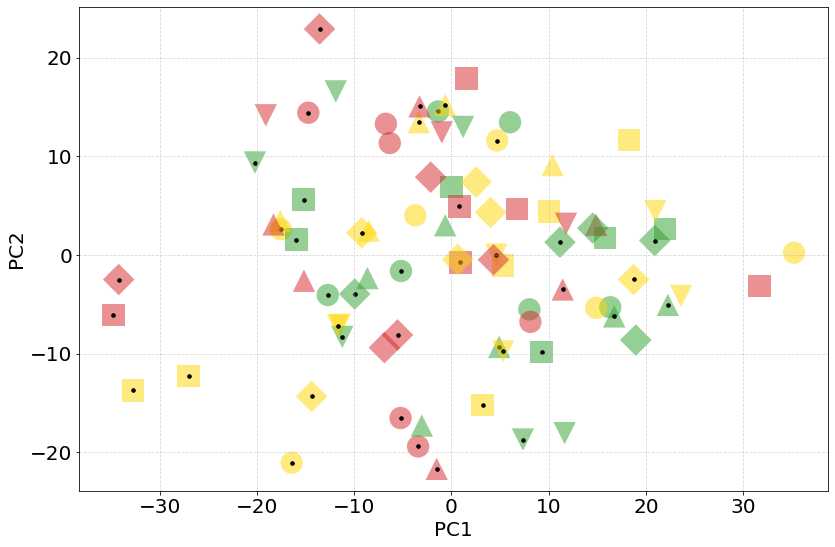

In [32]:
for i in range(len(x)):
    
    # marker based on patient
    patient = result.iloc[i, 2]
    if patient == 1:
        the_marker = 'o'
    elif patient == 2:
        the_marker = 's'
    elif patient == 3:
        the_marker = '^'
    elif patient == 4:
        the_marker = 'v'
    elif patient == 5:
        the_marker = 'D'
    else:
        print('error1')
    
    # color based on treatment
    treatment = result.iloc[i, 0]
    if treatment == 1:
        the_color = 'tab:green'
    elif treatment == 10:
        the_color = 'gold'
    elif treatment == 100:
        the_color = 'tab:red'
    else:
        print('error2')
    
    matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c=the_color, s=500, alpha=0.5, edgecolors='none', marker=the_marker)
    
    if result.iloc[i, 1] == 24:
        matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c='black', s=50, edgecolors='black', marker='.')
        
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(alpha=0.5, ls='--')
matplotlib.pyplot.tight_layout()

## 7.3. store results

In [33]:
storing_file = '/home/adrian/gd15/hi/research/huvec/results/untargeted/patient-specific/patient-specific_zscores.csv'
result.to_csv(storing_file)
print(result.shape)
result.head()

(85, 1153)


,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052049999999994,X78.956770000000006,X79.955420000000004,...,X970.29764,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
12,1,4,1,1.243431,-0.974653,1.150452,-0.635677,0.119016,0.200376,0.038294,...,0.284274,0.262986,0.207467,0.483277,1.059722,-1.308113,0.701503,1.188250,0.709572,0.707373
13,1,4,1,-0.230842,0.631825,-0.890577,-1.533015,0.807492,-1.408191,1.239277,...,-0.097424,-0.087549,-0.351609,-0.482578,-0.656099,0.885735,-1.310091,-0.737162,-0.424090,-0.347052
14,1,4,1,-0.029839,0.004819,0.687581,0.040550,0.401157,-0.196764,0.439138,...,0.837140,0.797144,1.094951,1.662275,-0.423716,0.420439,-0.406431,0.024816,0.271119,-0.010812
26,10,4,1,-0.432852,0.504271,-0.058546,0.531101,-0.543504,-0.487049,0.199540,...,-0.113157,-0.170302,-0.020699,0.062560,1.215522,-0.332394,0.912311,0.882983,-0.837075,0.646308
27,10,4,1,-0.660220,-0.080240,1.634516,0.156962,-0.623862,0.287818,-2.624065,...,2.483881,2.708892,2.304652,1.945389,1.129718,0.070639,-0.660211,-0.455263,-0.627390,-0.199372
